In [1]:
import sys 
sys.path.append("..\\..\\src")
import torch.nn as nn
import torch.nn.functional as F
import torch
import cv2
import pandas as pd
import numpy as np
from grad_cam import GradCam,show_cam_on_image
from pandas import DataFrame
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import PILImageDataset
from PIL import Image

In [2]:
img_size = (512, 512)
transform = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

df = pd.read_csv('df.csv')
model_path = 'new_test.pt'

trainset = PILImageDataset(df, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_list = nn.ModuleList([nn.Conv2d(3, 6, 17), nn.Conv2d(6, 16, 11),
                          nn.Conv2d(16, 32, 7), nn.Conv2d(32, 64, 5)])
        self.fc_list = nn.ModuleList([nn.Linear(43264, 120), nn.Linear(120, 84), nn.Linear(84, 10)])
    
    def feed_forward(self, x, nnlayer, conv =True):
        if conv==True:
            x = self.pool(F.relu(nnlayer(x)))
        else:
            x = F.relu(nnlayer(x))
        return x            
            
    
    def forward(self, x):
        for conv_layer in self.conv_list:
            x = self.feed_forward(x, conv_layer, conv =True)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        for fc in self.fc_list:
            x = self.feed_forward(x, fc, conv =False)
        return x

model = Net()

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times
    print('epoch : ', epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('running_loss : ', running_loss)

print('Finished Training')

epoch :  0
running_loss :  2.290736436843872
epoch :  1
running_loss :  2.2905349731445312
epoch :  2
running_loss :  2.2901558876037598
epoch :  3
running_loss :  2.289614677429199
epoch :  4
running_loss :  2.2889437675476074
epoch :  5
running_loss :  2.2881417274475098
epoch :  6
running_loss :  2.2872419357299805
epoch :  7
running_loss :  2.2862823009490967
epoch :  8
running_loss :  2.285255193710327
epoch :  9
running_loss :  2.28415846824646
Finished Training


In [5]:
torch.save(model, model_path)

In [6]:
img = Image.open('./data/Elephant/elephant.jpg')
img = img.resize(img_size)

inputs = torch.unsqueeze(transform(img),0)

In [7]:
grad_cam = GradCam(model=model, use_cuda=False)
target_index = None
mask_dict = grad_cam(inputs, target_index)
for name, mask in mask_dict.items():
    cam, name, heatmap = show_cam_on_image(img, mask, name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


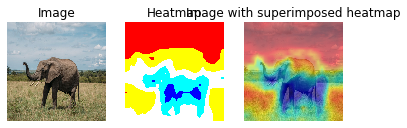

In [8]:
def plot_image_data(heatmap, cam, image):
    fig, axes = plt.subplots(nrows=1, ncols = 3)
    titles = ['Image', 'Heatmap', 'Image with superimposed heatmap']
    axes[0].imshow(image)
    axes[1].imshow(heatmap,)
    axes[2].imshow(cam)
    for i, ax in enumerate(axes):
        ax.axis('off')
        axes[i].set_title(titles[i])
    plt.show()
plot_image_data(heatmap, cam, img)